### TOPIC Identification of Mathematical word problems
Using TFIDF  - Complete 100K Dataset

### Read the DeepMind AQUA Data Set (.json file)

In [1]:
import pandas as pd
import numpy as np
import json 

import nltk
import string

In [2]:
qb =  pd.read_json('AQuA-master/train.json',lines=True)
qb.columns

Index(['correct', 'options', 'question', 'rationale'], dtype='object')

In [3]:
qb.head()

,correct,options,question,rationale
0,E,"[A)21, B)21.5, C)22, D)22.5, E)23]","Two friends plan to walk along a 43-km trail, ...","If Q complete x kilometers, then P completes 1..."
1,C,"[A)4 and 1, B)1 and 5, C)5 and 1, D)3 and 5, E...","In the coordinate plane, points (x, 1) and (5,...",Line k passes through the origin and has slope...
2,B,"[A)II, B)I and II, C)I and III, D)II and III, ...","For all numbers p and q, the operation @ is de...",p@q = p^2 - pq=p(p-q).... so p@q will be zero ...
3,A,"[A)$1600, B)$2000, C)$2150, D)$2500, E)$12000]",Carl is facing very difficult financial times ...,"Usually, you are given the annual rate of inte..."
4,E,"[A)18 seconds, B)27 seconds, C)26 seconds, D)1...",The speed at which a man can row a boat in sti...,Speed of the boat downstream = 25 +11\n= 36 km...


### Functions to remove the named entities 

In [4]:
def untokenize(tokens):
    return("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip())

def extract_nonentities(tree):
    tokens = [leaf[0] for leaf in tree if type(leaf) != nltk.Tree]
    return(untokenize(tokens))

def ne_removal(text_list):
    token_list = [nltk.word_tokenize(text) for text in text_list]
    tagged = nltk.pos_tag_sents(token_list)
    chunked = nltk.ne_chunk_sents(tagged)
    non_entities = []
    for tree in chunked:
        non_entities.append(extract_nonentities(tree))
    return(non_entities)

In [5]:
# removal of named entities
#qb['qn'] = ne_removal(qb['question'])
qb['qn'] = (qb['question'])



### Text Pre Processing 

In [6]:
## remove numerals , replace % with percent and convert to lowercase
import re
qb.qn = qb.qn.apply(lambda x: x.lower())
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\%', 'percent', x))
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\d+', '', x))

print(qb.qn.iloc[:3])

0    two friends plan to walk along a -km trail, st...
1    in the coordinate plane, points (x, ) and (, y...
2    for all numbers p and q, the operation @ is de...
Name: qn, dtype: object


In [7]:
questions=qb.question

### TFIDF vectorizer

In [8]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

In [9]:
# Instantiate the TFIDF vectorizer
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    max_features=30000)

# fit and transform on it the training features
tfidf_matrix = word_vectorizer.fit_transform(qb.qn)

print(tfidf_matrix.shape)

(97467, 14379)


In [10]:
terms = word_vectorizer.get_feature_names()
#print(terms)


### KMeans Clustering 

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline

km = KMeans(n_clusters=10,random_state=10,verbose=0)
clusters = km.fit_predict(tfidf_matrix)


In [12]:
print(len(clusters))


97467


In [13]:
qb['cluster']=clusters

In [15]:
a=qb['cluster'].unique()
b=qb['cluster'].value_counts()

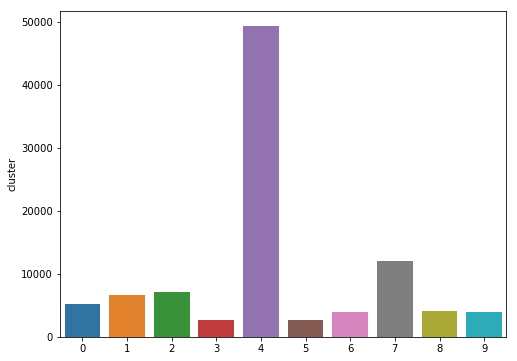

In [17]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.barplot(a,b,ax=ax)


### Lets look at the clusters in the question 

In [18]:
grouped = qb['question'].groupby(qb['cluster']) #groupby cluster for aggregation purposes


### Dimension Reduction of TFIDF matrix with SVD

In [19]:
from sklearn.decomposition import TruncatedSVD
svd_m = TruncatedSVD(n_components=2,  algorithm='randomized', n_iter=10, random_state=42)
svd = svd_m.fit_transform(tfidf_matrix)
print(svd.shape)
   

(97467, 2)


In [20]:
qb["x"] = svd[:,0]
qb["y"] = svd[:,1]

qb.head(10)

,correct,options,question,rationale,qn,cluster,x,y
0,E,"[A)21, B)21.5, C)22, D)22.5, E)23]","Two friends plan to walk along a 43-km trail, ...","If Q complete x kilometers, then P completes 1...","two friends plan to walk along a -km trail, st...",4,0.104853,0.067397
1,C,"[A)4 and 1, B)1 and 5, C)5 and 1, D)3 and 5, E...","In the coordinate plane, points (x, 1) and (5,...",Line k passes through the origin and has slope...,"in the coordinate plane, points (x, ) and (, y...",4,0.031389,0.015983
2,B,"[A)II, B)I and II, C)I and III, D)II and III, ...","For all numbers p and q, the operation @ is de...",p@q = p^2 - pq=p(p-q).... so p@q will be zero ...,"for all numbers p and q, the operation @ is de...",7,0.108188,-0.070672
3,A,"[A)$1600, B)$2000, C)$2150, D)$2500, E)$12000]",Carl is facing very difficult financial times ...,"Usually, you are given the annual rate of inte...",carl is facing very difficult financial times ...,4,0.088258,-0.029868
4,E,"[A)18 seconds, B)27 seconds, C)26 seconds, D)1...",The speed at which a man can row a boat in sti...,Speed of the boat downstream = 25 +11\n= 36 km...,the speed at which a man can row a boat in sti...,2,0.187603,0.296358
5,A,"[A)8, B)9, C)10, D)11, E)12]","There are k-2 members in a certain band, inclu...","There are k-2 members in the band, and k-4 mem...","there are k- members in a certain band, includ...",4,0.042578,-0.026197
6,A,"[A)− 3 ≤ x ≤ 4, B)− 4 ≤ x ≤ 3, C)− 3 ≤ x ≤ 3, ...","If (x^2 + 4x - 11)/5 ≤ x + 1, then x could be ...",IMO A is correct answer\nsolving through eqaut...,"if (x^ + x - )/ ≤ x + , then x could be repres...",4,0.060506,-0.044316
7,E,"[A)10101, B)11000, C)10110, D)10111, E)10100]",Find the smallest number of five digits exactl...,Smallest number of five digits is 10000.\nRequ...,find the smallest number of five digits exactl...,7,0.155538,-0.104855
8,B,"[A)16, B)20.5, C)17.5, D)20, E)4.5]",The entrance fee for a fair is $5 for persons ...,Total entrance fee is (2*$5) + (1.20*5)= $16\n...,the entrance fee for a fair is $ for persons u...,4,0.098741,-0.035025
9,C,"[A)15, B)31, C)12, D)27, E)91]",If X and Y are digits and 8XY is a 3-digit num...,Key to this question is to remember the fact t...,if x and y are digits and xy is a -digit numbe...,7,0.198495,-0.139817


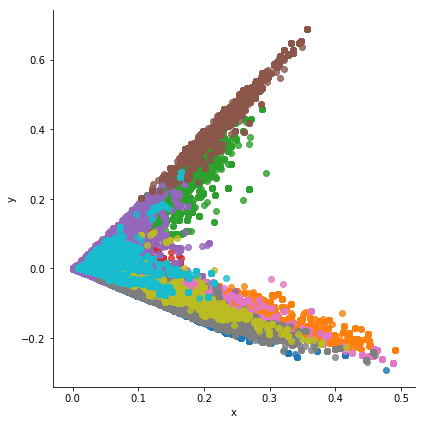

In [24]:
import seaborn as sns
%matplotlib inline

sns.lmplot( x="x", y="y", data=qb, fit_reg=False, hue='cluster', legend=False,size=6, aspect=1);


In [25]:
for key, item in grouped:
    print('-'*80)
    print("Questions in Cluster ",key)
    print('-'*80)
    x = grouped.get_group(key)
    cnt=0
    for i in x:
        print("[",cnt,"]",i)
        cnt=cnt+1;
        if (cnt>20):
            break
        

--------------------------------------------------------------------------------
Questions in Cluster  0
--------------------------------------------------------------------------------
[ 0 ] If a/b=3/4 and 8a+5b=22,then find the value of a.
[ 1 ] What is the least value of x, So that 2x5475 is divisible by 9
[ 2 ] If x is the product of the integers from 1 to 150, inclusive, and 5^y is a factor of x, what is the greatest possible value of y ?
[ 3 ] What is the greatest possible value of integer n if 100! is divisible by 15^n
[ 4 ] If 2^(2w) = 8^(w−2), what is the value of w?
[ 5 ] If 100!/x is not an integer, which of the following could be the value of x?
[ 6 ] If a - b = 2 and a2 + b2 = 25, find the value of ab.
[ 7 ] If x and y are integers such that (x+1)^2 is less than or equal to 16 and (y-1)^2 is less than 64, what is the sum of the maximum possible value of xy and the minimum possible value of xy?
[ 8 ] If k^3 is divisible by 120, what is the least possible value of integer k?